In [13]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from scipy.stats import poisson, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data = pd.DataFrame(pd.read_csv('../Twitter Sentiment/cleanedNspelt.csv'))

def helper(string):
    temp = []
    for word in string[1:-1].split(','):
        word = word.strip()
        word = word[1:-1]
        if word:
          temp.append(word)  
    return temp
data.filtered_tokens = data.filtered_tokens.apply(helper)

Use if machine not strong

In [15]:
#data = data.iloc[25000:75000]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.filtered_tokens, data.labels, stratify = data.labels, test_size=0.2, random_state=42)

In [17]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

Baseline Model when K = 1000 to find optimal parameters for RF

In [18]:
test1 = SelectKBest(score_func=chi2, k=1000)

X_train_new = test1.fit_transform(one_hot_encoded, y_train)

In [19]:
rf = RandomForestClassifier()
distributions = {'n_estimators': poisson(50), 'max_depth': poisson(10)}
rscv = RandomizedSearchCV(rf, distributions, random_state=42, n_jobs=-1, verbose=2, n_iter = 30)
rscv.fit(X_train_new, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205079BBEE0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205079B9F30>},
                   random_state=42, verbose=2)

In [20]:
rscv.best_estimator_

RandomForestClassifier(max_depth=18, n_estimators=50)

In [21]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test1.transform(X_test_new)

In [22]:
y_pred = rscv.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))


Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.78      0.56      0.65     10000
           1       0.66      0.84      0.74     10000

    accuracy                           0.70     20000
   macro avg       0.72      0.70      0.69     20000
weighted avg       0.72      0.70      0.69     20000



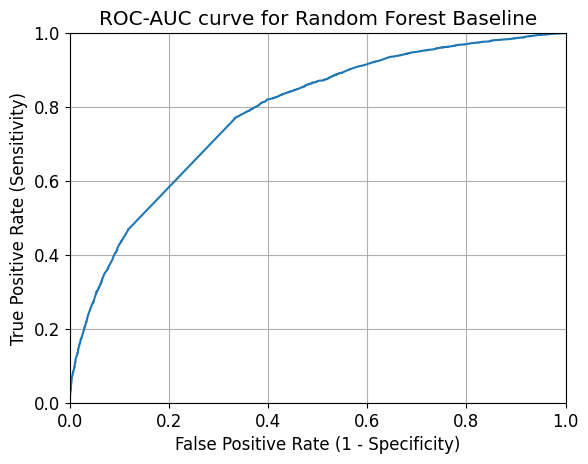

In [23]:
y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [24]:
print(roc_auc_score(y_test, y_pred_prob))

0.7814913


Now we try different number of columns selected by chi2 starting with 100

In [26]:
test2 = SelectKBest(score_func=chi2, k=100)

X_train_new = test2.fit_transform(one_hot_encoded, y_train)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf2.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

As we can see, accuracy has dipped slightly showing that having more columns might increase accuracy. Hence we attempt to prove this hypothesis by adding more columns.

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.77      0.52      0.62     10000
           1       0.64      0.84      0.72     10000

    accuracy                           0.68     20000
   macro avg       0.70      0.68      0.67     20000
weighted avg       0.70      0.68      0.67     20000

0.7562451649999999


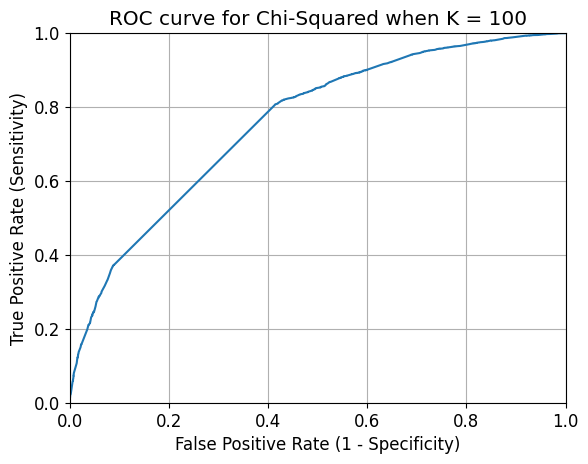

In [27]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test2.transform(X_test_new)
y_pred = clf2.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf2.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 100')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(roc_auc_score(y_test, y_pred_prob))

Now we try to select the best 10000 columns

In [28]:
test3 = SelectKBest(score_func=chi2, k=10000)

X_train_new = test3.fit_transform(one_hot_encoded, y_train)
clf3 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf3.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.77      0.60      0.67     10000
           1       0.67      0.82      0.74     10000

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.71     20000
weighted avg       0.72      0.71      0.71     20000

0.785252415


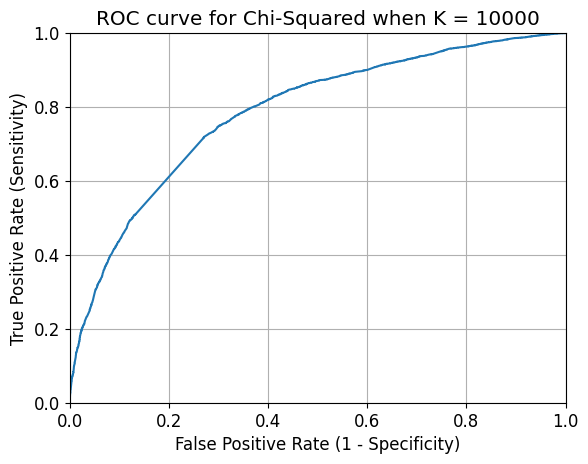

In [29]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test3.transform(X_test_new)
y_pred = clf3.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf3.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 10000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(roc_auc_score(y_test, y_pred_prob))

Same can be said when number of columns selected is 20000 by the increases in accuracy are diminishing.

In [30]:
test4 = SelectKBest(score_func=chi2, k=20000)

X_train_new = test4.fit_transform(one_hot_encoded, y_train)
clf4 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf4.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.77      0.63      0.69     10000
           1       0.69      0.82      0.75     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

0.7965551399999999


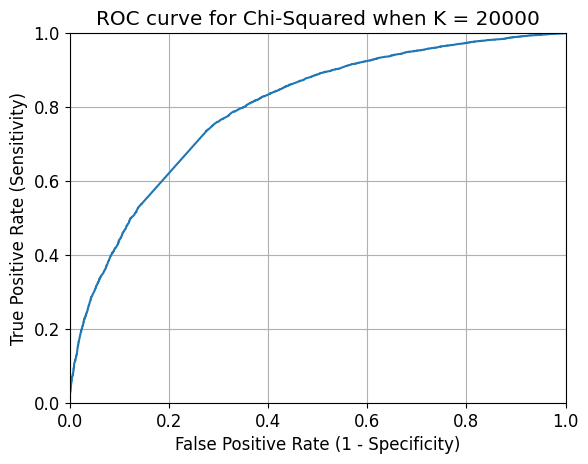

In [31]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test4.transform(X_test_new)
y_pred = clf4.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf4.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 20000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(roc_auc_score(y_test, y_pred_prob))

In [32]:
test5 = SelectKBest(score_func=chi2, k=30000)

X_train_new = test5.fit_transform(one_hot_encoded, y_train)
clf5 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf5.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.76      0.64      0.70     10000
           1       0.69      0.80      0.74     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

0.7895061800000001


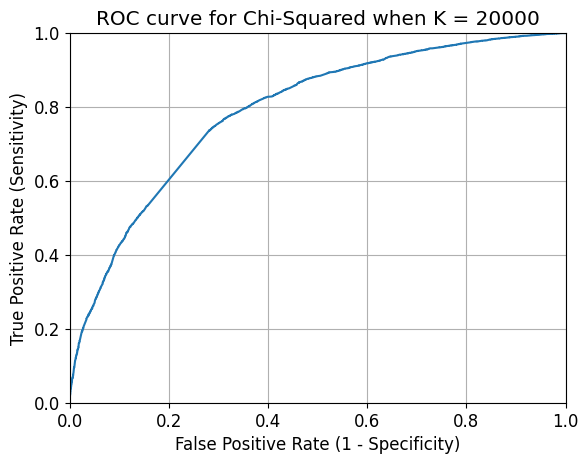

In [33]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test5.transform(X_test_new)
y_pred = clf5.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf5.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 20000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(roc_auc_score(y_test, y_pred_prob))

Apart from chi2 we try other alternative methods for decomposition of our data, here we try truncated SVD which is more suitable as our data is very large and sparse

In [36]:
# Create a PCA instance
SVD = TruncatedSVD(n_components=100)

# Fit and transform your one-hot encoded data
SVD.fit(one_hot_encoded)

explained_variance = SVD.explained_variance_

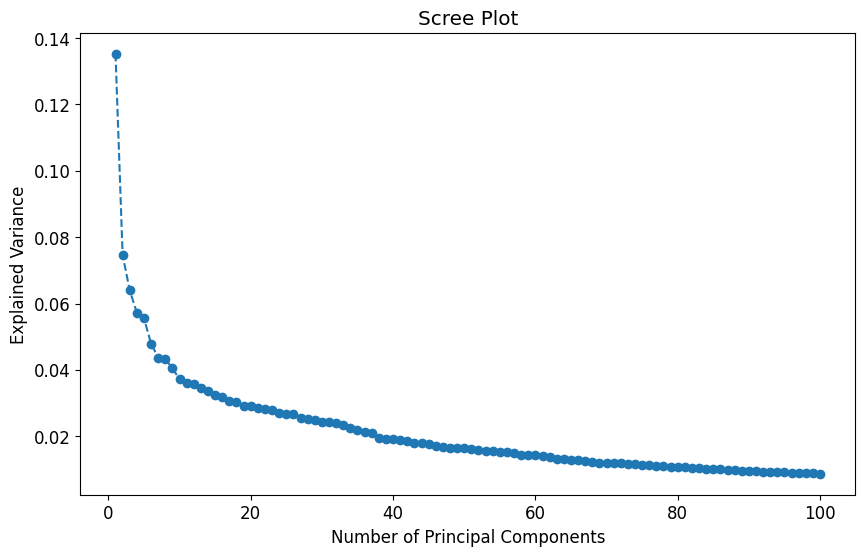

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

From the scree plot, we can see that the kink is around where the number of principal components is 20, hence we use this number going forward.

In [38]:
SVD = TruncatedSVD(n_components=20)
X_train_new = SVD.fit_transform(one_hot_encoded)
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42)
rf_classifier.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42)

In [40]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = SVD.transform(X_test_new)
y_pred = rf_classifier.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))

Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.70      0.67      0.68     10000
           1       0.68      0.72      0.70     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



0.763835085


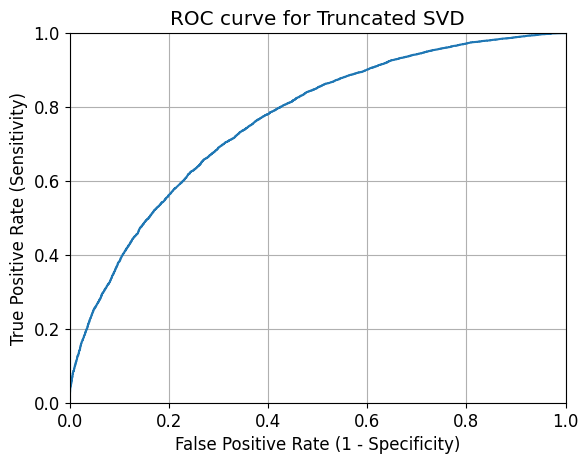

In [42]:
y_pred_prob = rf_classifier.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Truncated SVD')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(roc_auc_score(y_test, y_pred_prob))

We can see that TruncatedSVD seems to perfrom slightly worse, next we try tfidf

In [45]:
# TF-IDF
sentences = [' '.join(words) for words in X_train]

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

In [46]:
clf = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs=-1)
clf.fit(tfidf_matrix,y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.69765
              precision    recall  f1-score   support

           0       0.77      0.56      0.65     10000
           1       0.66      0.83      0.73     10000

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.69     20000
weighted avg       0.71      0.70      0.69     20000

0.7754476800000001


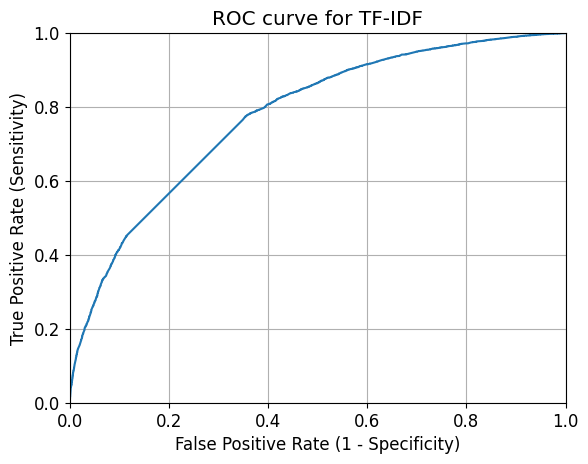

In [49]:
sen = [' '.join(words) for words in X_test]
X_test_new = tfidf_vectorizer.transform(sen)
y_pred = clf.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(report)

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for TF-IDF')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(roc_auc_score(y_test, y_pred_prob))